### Import libraries

In [12]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import optuna
import hydra
from omegaconf import OmegaConf
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns

# device setup
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### Utility functions

In [3]:
def rmse(y_true, y_pred):
    y_true = np.square(y_true)
    y_pred = np.square(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def qlike(y_true, y_pred, eps=1e-12):
    y_true = np.square(y_true)
    y_pred = np.square(y_pred)
    ratio = (y_true + eps) / (y_pred + eps)
    return float(np.mean(ratio - np.log(ratio) - 1.0))

def calculate_metrics(df):
    return {'rmse' : rmse(df.value.values, df.prediction.values),
           'qlike' : qlike(df.value.values, df.prediction.values)
           }

def plot_predictions(df_result):
    data = []
    value = go.Scatter(
        x=df_result.index,
        y=df_result.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='predictions',
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)
    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )
    fig = dict(data=data, layout=layout)
    iplot(fig)

# inverse transform function for y
def inverse_transform_y(scaler_y, arr):
    inv = scaler_y.inverse_transform(arr.reshape(-1,1)).ravel()
    return inv

# format predictions into a dataframe
def format_predictions(predictions, values, df_test_index, scaler_y):
    # flatten preds and values
    if isinstance(predictions, list):
        preds_arr = np.concatenate([p.reshape(-1) for p in predictions], axis=0)
    else:
        preds_arr = np.array(predictions).reshape(-1)

    vals_arr = np.concatenate([v.reshape(-1) for v in values], axis=0)

    # inverse transform
    preds_inv = inverse_transform_y(scaler_y, preds_arr)
    vals_inv = inverse_transform_y(scaler_y, vals_arr)

    n = min(len(vals_inv), len(preds_inv), len(df_test_index))
    idx = df_test_index[:n]

    df_result = pd.DataFrame(data={"value": vals_inv[:n], "prediction": preds_inv[:n]}, index=idx)
    df_result = df_result.sort_index()
    return df_result


### Load dataset

In [4]:
# load dataset
df = pd.read_csv("../Data/eth_final_df.csv")
df = df.rename(columns={'vol_future': 'value'})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(['timestamp'])
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)
df.head()

,RV_MA_1hr,RV_MA_3hr,RV_MA_12hr,value,active_sending_addresses,active_receiving_addresses,exchange_withdrawing_count,transaction_count,fail_rate_percent,open,...,exchange_netflow_usd_log,whale_net_usd,whale_net_usd_24h,whale_burst_flag,etow_usd_log,etow_coins_log,whale_txn_count_log,wtoe_usd_log,wtoe_coins_log,btc_to_eth_spill
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-05 00:00:00+00:00,0.007329,0.010102,0.006048,0.009336,20914,12008,6340,44719,1.317284,2398.91,...,15.335639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029077
2024-11-05 01:00:00+00:00,0.004471,0.006700,0.006063,0.003825,20028,12945,5877,44513,1.239836,2402.45,...,-13.782015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052534
2024-11-05 02:00:00+00:00,0.009336,0.007045,0.006538,0.003505,21410,12831,5846,45224,0.950002,2411.90,...,16.147527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064565
2024-11-05 03:00:00+00:00,0.003825,0.005877,0.006426,0.003399,20210,12622,5429,42689,-0.071795,2405.17,...,15.417117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105441
2024-11-05 04:00:00+00:00,0.003505,0.005555,0.006192,0.003244,21076,10843,5454,43063,-0.071795,2418.50,...,15.517485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131129


### Dataloaders functions

In [5]:
def make_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size):
    scaler_x = MinMaxScaler()
    X_train_arr = scaler_x.fit_transform(X_train)
    X_val_arr = scaler_x.transform(X_val)
    X_test_arr = scaler_x.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train_arr = scaler_y.fit_transform(y_train)
    y_val_arr = scaler_y.transform(y_val)
    y_test_arr = scaler_y.transform(y_test)

    # Torch tensors
    train_features = torch.Tensor(X_train_arr)
    train_targets = torch.Tensor(y_train_arr)
    val_features = torch.Tensor(X_val_arr)
    val_targets = torch.Tensor(y_val_arr)
    test_features = torch.Tensor(X_test_arr)
    test_targets = torch.Tensor(y_test_arr)

    # TensorDatasets
    train = TensorDataset(train_features, train_targets)
    val = TensorDataset(val_features, val_targets)
    test = TensorDataset(test_features, test_targets)

    # DataLoaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader, test_loader_one, scaler_x, scaler_y

def make_final_dataloaders(X_train, X_test, y_train, y_test, batch_size):
    scaler_x = MinMaxScaler()
    X_train_arr = scaler_x.fit_transform(X_train)
    X_test_arr = scaler_x.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train_arr = scaler_y.fit_transform(y_train)
    y_test_arr = scaler_y.transform(y_test)

    train = TensorDataset(torch.Tensor(X_train_arr), torch.Tensor(y_train_arr))
    test = TensorDataset(torch.Tensor(X_test_arr), torch.Tensor(y_test_arr))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

    return train_loader, test_loader, test_loader_one, scaler_x, scaler_y

### Data split functions

In [6]:
# time series train/val/test split with purge (without rolling splits for final evaluation)
def time_series_train_val_test_split(df, train_size=0.7, val_size=0.15, purge_hours=24):
    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)
    purge = int(purge_hours)
    train = df.iloc[:train_end].copy()
    val = df.iloc[train_end + purge : val_end].copy()
    test = df.iloc[val_end + purge :].copy()
    return train, val, test

# rolling splits with purge and validation set (time series cross-validation for hyperparameter tuning)
def rolling_splits_with_val(df, target_col, n_splits=5, purge_hours=24, val_ratio=0.15):
    df = df.sort_index()
    X = df.drop(columns=[target_col])
    y = df[[target_col]]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []

    for train_idx, test_idx in tscv.split(X):
        last_train_pos = train_idx[-1]
        allowed_test_idx = test_idx[test_idx > last_train_pos + purge_hours]
        if len(allowed_test_idx) == 0:
            continue
        n_train = len(train_idx)
        val_size = max(1, int(n_train * val_ratio))
        train_cut = n_train - val_size
        train_sub_idx = train_idx[:train_cut]
        val_sub_idx = train_idx[train_cut:]

        X_train = X.iloc[train_sub_idx].copy()
        X_val = X.iloc[val_sub_idx].copy()
        X_test = X.iloc[allowed_test_idx].copy()
        y_train = y.iloc[train_sub_idx].copy()
        y_val = y.iloc[val_sub_idx].copy()
        y_test = y.iloc[allowed_test_idx].copy()
        splits.append((X_train, X_val, X_test, y_train, y_val, y_test))

    return splits

### LSTM model

In [7]:
class LSTMModel(pl.LightningModule):
    def __init__(self, loss_fn, input_dim=1, hidden_dim=64, layer_dim=2,
                 output_dim=1, dropout=0.1, learning_rate=1e-4, weight_decay=1e-6):
        super().__init__()
        self.loss_fn = loss_fn
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.dropout = dropout

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.save_hyperparameters()

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        batch_size = x.size(0)
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        pred = self.forward(x)
        loss = nn.MSELoss()(pred, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        pred = self.forward(x)
        loss = torch.sqrt(nn.MSELoss()(pred, y))
        self.log('val_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        x = x.to(self.device)
        return self.forward(x).detach().cpu().numpy()


In [8]:
@hydra.main(version_base=None, config_path=None, config_name=None)
def main(cfg):
    # load dataset
    df = pd.read_csv("../Data/btc_final_df.csv")
    df = df.rename(columns={'vol_future': 'value'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index(['timestamp']).sort_index()
    df.fillna(0, inplace=True)

    mode = cfg.mode.lower()

    # Hyperparameter tuning: rolling CV (5 fold)
    if mode == "tune":
        def objective(trial):
            hidden_dim = trial.suggest_categorical("hidden_dim", [16, 32, 64])
            layer_dim = trial.suggest_categorical("layer_dim", [1, 2, 4])
            dropout = trial.suggest_float("dropout", 0.1, 0.2)
            batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32])

            splits = rolling_splits_with_val(df, cfg.target_col, n_splits=5,
                                             purge_hours=cfg.purge_hours, val_ratio=cfg.val_ratio)
            val_losses = []
            for X_train, X_val, X_test, y_train, y_val, y_test in splits:
                train_loader, val_loader, _, _, _, _ = make_dataloaders(
                    X_train, X_val, X_test, y_train, y_val, y_test, batch_size
                )
                model = LSTMModel(nn.MSELoss(), input_dim=X_train.shape[1],
                                  hidden_dim=hidden_dim, layer_dim=layer_dim, dropout=dropout)
                trainer = pl.Trainer(max_epochs=cfg.n_epochs, accelerator="auto", devices=1,
                                     callbacks=[EarlyStopping(monitor="val_loss", patience=cfg.patience)],
                                     logger=False, enable_progress_bar=False)
                trainer.fit(model, train_loader, val_loader)
                val_loss = trainer.validate(model, val_loader, verbose=False)[0]["val_loss"]
                val_losses.append(val_loss)

            return np.mean(val_losses)

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=cfg.n_trials)
        print("Best hyperparameters:", study.best_params)
        return study.best_params

    # Final evaluation with best hyperparameters
        # Final evaluation with best hyperparameters
    elif mode == "final":
        best_params = cfg.best_params
        df_train, df_val, df_test = time_series_train_val_test_split(
            df, train_size=cfg.train_size, val_size=cfg.val_size, purge_hours=cfg.purge_hours
        )

        X_train_final = pd.concat([df_train.drop(columns=[cfg.target_col]),
                                   df_val.drop(columns=[cfg.target_col])]).sort_index()
        y_train_final = pd.concat([df_train[[cfg.target_col]],
                                   df_val[[cfg.target_col]]]).sort_index()
        X_test = df_test.drop(columns=[cfg.target_col])
        y_test = df_test[[cfg.target_col]]

        train_loader, test_loader, test_loader_one, scaler_X, scaler_y = make_final_dataloaders(
            X_train_final, X_test, y_train_final, y_test, best_params["batch_size"]
        )

        model = LSTMModel(nn.MSELoss(), input_dim=X_train_final.shape[1],
                          hidden_dim=best_params["hidden_dim"],
                          layer_dim=best_params["layer_dim"],
                          dropout=best_params["dropout"])

        trainer = pl.Trainer(max_epochs=cfg.n_epochs, accelerator="auto", devices=1,
                             callbacks=[], logger=False, enable_progress_bar=False,
                             enable_checkpointing=False)
        trainer.fit(model, train_loader)

        preds = trainer.predict(model, dataloaders=test_loader_one)
        values = [y.numpy() for _, y in test_loader_one]

        df_result = format_predictions(preds, values, X_test.index, scaler_y)
        metrics = calculate_metrics(df_result)
        print("Final evaluation metrics:", metrics)

        # Captum feature importance
        from captum.attr import IntegratedGradients

        def compute_feature_importance_captum(model, dataloader, feature_names):
            model.eval()
            ig = IntegratedGradients(model)
            all_attr = []

            for batch in dataloader:
                inputs, _ = batch
                inputs = inputs.to(model.device)
                if len(inputs.shape) == 2:
                    inputs = inputs.unsqueeze(1)
                attributions, _ = ig.attribute(inputs, target=None, return_convergence_delta=True)
                all_attr.append(attributions.detach().cpu().numpy())

            attr_array = np.concatenate(all_attr, axis=0)
            avg_attr = np.mean(np.abs(attr_array), axis=(0, 1))
            feature_importance = pd.DataFrame({
                "feature": feature_names,
                "importance": avg_attr / np.sum(avg_attr)
            }).sort_values("importance", ascending=False)
            return feature_importance

        feature_names = list(X_test.columns)
        feature_importance = compute_feature_importance_captum(model, test_loader, feature_names)
        print("\nFeature Importance (Integrated Gradients):")
        print(feature_importance)
        return df_result, metrics, feature_importance


    else:
        raise ValueError("Unknown mode. Choose 'tune' or 'final'.")

### Run tuning

In [9]:
# hyperparameter tuning
cfg_tune = OmegaConf.create({
    "mode": "tune",
    "target_col": "value",
    "train_size": 0.7,
    "val_size": 0.15,
    "purge_hours": 24,
    "val_ratio": 0.15,
    "n_trials": 5,
    "n_epochs": 20,
    "patience": 5
})
best_params = main(cfg_tune)


[I 2025-10-31 23:48:32,611] A new study created in memory with name: no-name-55a5c62b-9ed1-44cc-84dd-451fe9b58320
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lstm    | LSTM    | 123 K  | train
2 | fc      | Linear  | 65     | train
--------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.494     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable Li

Best hyperparameters: {'hidden_dim': 32, 'layer_dim': 4, 'dropout': 0.1583720080524094, 'batch_size': 4}


### Run final evaluation and feature importance

In [10]:
# final evaluation
cfg_final = OmegaConf.create({
    "mode": "final",
    "target_col": "value",
    "train_size": 0.7,
    "val_size": 0.15,
    "purge_hours": 24,
    "best_params": best_params,
    "n_epochs": 20
})
preds_concat, metrics, feature_importance = main(cfg_final)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lstm    | LSTM    | 33.0 K | train
2 | fc      | Linear  | 33     | train
--------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Final evaluation metrics: {'rmse': 0.0007173611083999276, 'qlike': 1.1266776323318481}

Feature Importance (Integrated Gradients):
                       feature  importance
4                         open    0.158941
15                  RV_MA_12hr    0.098654
14                   RV_MA_3hr    0.089183
7                        close    0.087809
17               whale_net_usd    0.082672
13                   RV_MA_1hr    0.067889
9                total_fee_usd    0.062687
3           onchain_volume_usd    0.056436
8              mint_reward_usd    0.043570
23                wtoe_usd_log    0.030173
18           whale_net_usd_24h    0.029874
20                etow_usd_log    0.025973
5                          low    0.025092
0     btc_exchange_netflow_usd    0.024620
16               hourly_return    0.023298
11      exchange_to_wallet_usd    0.022470
10           transaction_count    0.014355
1     active_sending_addresses    0.014165
2   active_receiving_addresses    0.014106
6        

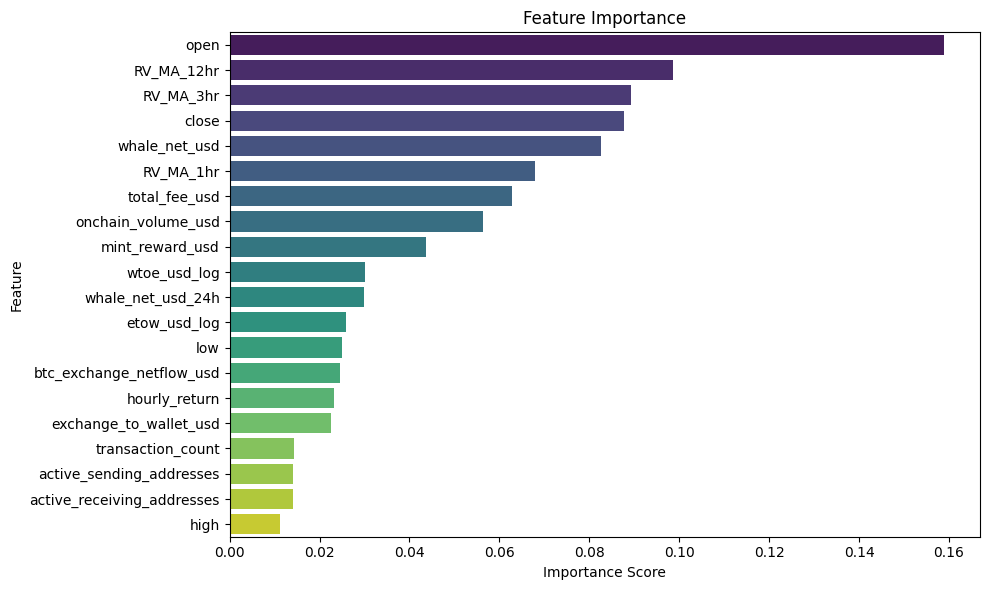

In [14]:
feature_importance_df = pd.DataFrame({
    "feature": feature_importance.feature,
    "importance": feature_importance.importance
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(20),  # top 20 features
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Plot and save results

In [ ]:
# plot final predictions
plot_predictions(preds_concat)

In [ ]:
df_all_predictions = preds_concat.reset_index().rename(columns={'index': 'timestamp', 'value': 'vol_future', 'prediction': 'pred_vol_future'})
df_all_predictions.head()

,timestamp,vol_future,pred_vol_future
0,2025-08-23 16:00:00+00:00,0.001425,0.002783
1,2025-08-23 17:00:00+00:00,0.001241,0.002461
2,2025-08-23 18:00:00+00:00,0.001540,0.002294
3,2025-08-23 19:00:00+00:00,0.001522,0.001930
4,2025-08-23 20:00:00+00:00,0.001706,0.001970


In [ ]:
df_all_predictions.to_csv("../Results/eth_lstm_prediction.csv", index=False)